<a href="https://colab.research.google.com/github/Hubert26/suicides_IPPAN/blob/main/ml_analize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Liblaries and settings

In [115]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.figure_factory as ff
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, roc_curve, confusion_matrix, classification_report
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz

from google.colab import files

#Ustawienie braku maksymalnej ilości wyświetlanych kolumn
pd.options.display.max_columns = None

np.random.seed(42)

#Function definitions

## display_info

In [116]:
def display_info(df, selected_columns):
    print(selected_columns)
    print(len(selected_columns))
    for col_name in selected_columns:

        # Mode
        print("\nMode:")
        print(df[col_name].mode())

        # NaN count
        nan_count = df[col_name].isna().sum()
        print("\nNaN count:", nan_count)

        # Unique values len
        print("\nUnique values len:")
        print(len(df[col_name].unique()))

        # Unique values
        print("\nUnique values:")
        print(df[col_name].unique())

        # Value counts
        print("\nValue counts:")
        print(df[col_name].value_counts())

        print("\n" + "=" * 40)  # Separator between columns


## create_bar_plot

In [117]:
def create_bar_plot(x_values, y_values, x_label, y_label, title, x_rotation=0):

    # Tworzenie wykresu słupkowego
    plt.bar(x_values, y_values)

    # Dodanie wartości nad słupkami
    for i in range(len(x_values)):
        plt.text(x_values[i], y_values[i], str(y_values[i]), ha='center', va='bottom')

    # Dodanie tytułu i etykiet osi
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    # Wyświetlenie wykresu
    plt.xticks(rotation=x_rotation, ha='right')
    plt.tight_layout()
    plt.show()


##create_double_bar_plot

In [118]:
def create_double_bar_plot(x_values, y_values1, y_values2, x_label, y_label, title, x_rotation=0):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))  # Tworzenie dwóch subplotów obok siebie

    # Utworzenie słupków dla obu serii danych
    bars1 = ax1.bar(x_values, y_values1, label='Series 1')
    bars2 = ax2.bar(x_values, y_values2, label='Series 2')

    # Dodanie wartości nad słupkami dla serii 1
    for bar in bars1:
        height = bar.get_height()
        ax1.annotate('{}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

    # Dodanie wartości nad słupkami dla serii 2
    for bar in bars2:
        height = bar.get_height()
        ax2.annotate('{}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

    # Dodanie tytułów i etykiet osi
    ax1.set_title(title)
    ax1.set_xlabel(x_label)
    ax1.set_ylabel(y_label)
    ax1.set_xticklabels(x_values, rotation=x_rotation, ha='right')

    ax2.set_xlabel(x_label)
    ax2.set_ylabel(y_label)
    ax2.set_xticklabels(x_values, rotation=x_rotation, ha='right')

    # Wyświetlenie wykresu
    plt.tight_layout()
    plt.show()

##plot_confusion_matrix

In [119]:
def plot_confusion_matrix(cm, model):
    # klasyfikacja binarna
    cm = cm[::-1]
    cm = pd.DataFrame(cm, columns=['pred_0', 'pred_1'], index=['true_1', 'true_0'])

    fig = ff.create_annotated_heatmap(z=cm.values, x=list(cm.columns), y=list(cm.index),
                                      colorscale='ice', showscale=True, reversescale=True)
    fig.update_layout(
        width=500,
        height=500,
        title=model+' Confusion Matrix',
        font_size=16,
        template='plotly_dark'
        )
    fig.show()
    return fig

##plot_roc_curve

**pogrubiony tekst**
 Receiver Operating Characteristic
1. True Positive Rate (TPR) = FP / (FP+TN)
2. False Positive Rate (FPR) = TP / (TP+FN)

In [120]:
def plot_roc_curve(y_test, y_pred, model):
    # Binary classification
    from sklearn.metrics import roc_curve
    fpr, tpr, tresh = roc_curve(y_test, y_pred, pos_label=1)

    fig = go.Figure(
        data=[
            go.Scatter(x=fpr, y=tpr,
                    line_color='red',
                    name='ROC Curve'),
            go.Scatter(x=[0, 1], y=[0, 1],
                    mode='lines',
                    line_dash='dash',
                    line_color='#F012BE')
        ],
        layout=go.Layout(xaxis_title='False Positive Rate',
                         yaxis_title='True Positive Rate',
                         title = model + ' ROC Curve',
                         showlegend=False,
                         template='plotly_dark',
                         width=700))
    fig.show()
    return fig


##model_validation


Precision (precyzja) = TP / (TP+FP): Ile obserwacji przewidzianych jako pozytywne jest w rzeczywistości pozytywne.

Recall (czułość) = TP / (TP+FN): Ile obserwacji z wszystkich pozywtywnych sklasyfikowaliśmy jako pozytywne.

F1-score: ważona średnia harmonicza między precyzją a czułością;

Support (wsparcie): liczba próbek, które należą do każdej z klas;

Accuracy (dokładność) = (TP+TN) /(TP+TN+FP+FN))

FPR (False Positive Rate) = FP / (FP+TN) [type I error]

FNR (False Negative Rate) = FN / (FN+TP) [type II error]

In [121]:
def model_validation(y_test, y_pred, model):
  from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred, average="weighted")
  recall = recall_score(y_test, y_pred, average="weighted")
  f1 = f1_score(y_test, y_pred, average="weighted")
  roc_score = roc_auc_score(y_test, y_pred)
  cm = confusion_matrix(y_test, y_pred)
  tn, fp, fn, tp = cm.ravel()
  fpr = fp / (fp + tn) # False Positive Rate - Type I error
  fnr = fn / (fn + tp) # False Negative Rate - Type II error

  model_results = pd.DataFrame([{'accuracy': accuracy,
                                 'precision': precision,
                                 'recall': recall,
                                 'f1': f1,
                                 'AUROC': roc_score,
                                 'fpr': fpr,
                                 'fnr': fnr
                                 }],
                                  index=[str(model)]
                               )
  return model_results

##plot_learning_curve

In [122]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :param train_sizes:
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

#Data exploration

In [123]:
df_raw = pd.read_csv('https://raw.githubusercontent.com/Hubert26/suicides_IPPAN/main/data/cleaned_samobojstwa_2013_2022.csv', delimiter=',', low_memory=False)

In [124]:
df_raw.head(5)

,ID_samobójcy,Data_raportu,Przedział_wiekowy,Płeć,Stan_cywilny,Wykształcenie,Informacje_o_pracy_i_nauce,Źródło_utrzymania,Czy_samobójstwo_zakończyło_się_zgonem,Miejsce_zamachu,Sposób_popełnienia,Stan_świadomości,Informacje_o_używaniu_substancji,Informacje_dotyczące_leczenia_z_powodu_alkoholizmu/narkomanii,Data_raportu_rok,Data_raportu_miesiąc,Liczba_powodów_zamachu,Powód_zamachu_Nieporozumienie rodzinne/przemoc w rodzinie,Powód_zamachu_Choroba psychiczna/zaburzenia psychiczne,Powód_zamachu_Problemy w szkole lub pracy,Powód_zamachu_Choroba fizyczna,Powód_zamachu_Nagła utrata źródła utrzymania,Powód_zamachu_Złe warunki ekonomiczne/długi,Powód_zamachu_Pogorszenie lub nagła utrata zdrowia,Powód_zamachu_Niepożądana ciąża,"Powód_zamachu_Mobbing, cybermobbing, znęcanie",Powód_zamachu_Zagrożenie lub utrata miejsca zamieszkania,Powód_zamachu_Inny niewymieniony,Powód_zamachu_Przewlekła choroba,Powód_zamachu_Dokonanie przestępstwa lub wykroczenia,Powód_zamachu_Śmierć bliskiej osoby,Powód_zamachu_Konflikt z osobami spoza rodziny,"Powód_zamachu_Nosiciel wirusa HIV, chory na AIDS",Powód_zamachu_Zawód miłosny,Powód_zamachu_Trwałe kalectwo
0,"114771204,00",5.2013,07-12,Kobieta,Kawaler/panna,Podstawowe,Uczeń,Na utrzymaniu innej osoby,0.0,Park/las,Samookaleczenie inne,Pod wpływem alkoholu,Nadużywał alkoholu,Leczony z powodu narkomanii,2013,5,1.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,"114815301,00",6.2013,07-12,Kobieta,Kawaler/panna,Podstawowe niepełne,Uczeń,Na utrzymaniu innej osoby,0.0,Park/las,Inny,Trzeźwy,Nadużywał narkotyków,Leczony z powodu alkoholizmu,2013,6,1.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"114936744,00",10.2013,07-12,Kobieta,Kawaler/panna,Podstawowe niepełne,Uczeń,Na utrzymaniu innej osoby,1.0,Mieszkanie/dom,Powieszenie się,Trzeźwy,Nadużywał alkoholu,Leczony z powodu alkoholizmu,2013,10,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,"114944870,00",10.2013,07-12,Mężczyzna,Kawaler/panna,Podstawowe,Uczeń,Na utrzymaniu innej osoby,0.0,Inne,Inny,Trzeźwy,Nadużywał narkotyków,Leczony z powodu narkomanii,2013,10,1.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,"114948230,00",10.2013,07-12,Kobieta,Kawaler/panna,Podstawowe niepełne,Uczeń,Na utrzymaniu innej osoby,1.0,"Piwnica, strych, garaż korytarz",Powieszenie się,Pod wpływem leków,Nadużywał dopalaczy,Leczony z powodu alkoholizmu,2013,10,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [125]:
age_group = sorted(list(set(df_raw['Przedział_wiekowy'])))
gender = ['Kobieta']
year = sorted(list(set(df_raw['Data_raportu_rok'])))

df_data = df_raw[df_raw['Przedział_wiekowy'].isin(age_group) & df_raw['Płeć'].isin(gender) & df_raw['Data_raportu_rok'].isin(year)]

In [126]:
name = "age_group_" + str(age_group) + "_gender_" + str(gender) + "_year_" + str(year)
name

"age_group_['07-12', '13-18', '19-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85+']_gender_['Kobieta']_year_[2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]"

##NaN exploration in variables

In [127]:
df_data.shape

(28771, 35)

In [128]:
df_data['Czy_samobójstwo_zakończyło_się_zgonem'].sum()

7913.0

In [129]:
##Brakujące dane
total = df_data.isnull().sum().sort_values(ascending=False)
percent = 100*(df_data.isnull().sum()/df_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

In [130]:
missing_data

,Total,Percent
ID_samobójcy,0,0.0
Powód_zamachu_Zagrożenie lub utrata miejsca zamieszkania,0,0.0
Powód_zamachu_Choroba fizyczna,0,0.0
Powód_zamachu_Nagła utrata źródła utrzymania,0,0.0
Powód_zamachu_Złe warunki ekonomiczne/długi,0,0.0
Powód_zamachu_Pogorszenie lub nagła utrata zdrowia,0,0.0
Powód_zamachu_Niepożądana ciąża,0,0.0
"Powód_zamachu_Mobbing, cybermobbing, znęcanie",0,0.0
Powód_zamachu_Inny niewymieniony,0,0.0
Powód_zamachu_Choroba psychiczna/zaburzenia psychiczne,0,0.0


In [131]:
df_data.drop(['ID_samobójcy', 'Data_raportu', 'Informacje_o_używaniu_substancji', 'Informacje_dotyczące_leczenia_z_powodu_alkoholizmu/narkomanii'], inplace=True,	 axis=1, errors='ignore')

In [132]:
df_data['Data_raportu_miesiąc'] = df_data['Data_raportu_miesiąc'].astype(str)
df_data['Data_raportu_rok'] = df_data['Data_raportu_rok'].astype(str)

#DTC

In [133]:
data_dummies = pd.get_dummies(df_data)

In [134]:
data_dummies.shape

(28771, 132)

In [135]:
data_dummies.head()

,Czy_samobójstwo_zakończyło_się_zgonem,Liczba_powodów_zamachu,Powód_zamachu_Nieporozumienie rodzinne/przemoc w rodzinie,Powód_zamachu_Choroba psychiczna/zaburzenia psychiczne,Powód_zamachu_Problemy w szkole lub pracy,Powód_zamachu_Choroba fizyczna,Powód_zamachu_Nagła utrata źródła utrzymania,Powód_zamachu_Złe warunki ekonomiczne/długi,Powód_zamachu_Pogorszenie lub nagła utrata zdrowia,Powód_zamachu_Niepożądana ciąża,"Powód_zamachu_Mobbing, cybermobbing, znęcanie",Powód_zamachu_Zagrożenie lub utrata miejsca zamieszkania,Powód_zamachu_Inny niewymieniony,Powód_zamachu_Przewlekła choroba,Powód_zamachu_Dokonanie przestępstwa lub wykroczenia,Powód_zamachu_Śmierć bliskiej osoby,Powód_zamachu_Konflikt z osobami spoza rodziny,"Powód_zamachu_Nosiciel wirusa HIV, chory na AIDS",Powód_zamachu_Zawód miłosny,Powód_zamachu_Trwałe kalectwo,Przedział_wiekowy_07-12,Przedział_wiekowy_13-18,Przedział_wiekowy_19-24,Przedział_wiekowy_25-29,Przedział_wiekowy_30-34,Przedział_wiekowy_35-39,Przedział_wiekowy_40-44,Przedział_wiekowy_45-49,Przedział_wiekowy_50-54,Przedział_wiekowy_55-59,Przedział_wiekowy_60-64,Przedział_wiekowy_65-69,Przedział_wiekowy_70-74,Przedział_wiekowy_75-79,Przedział_wiekowy_80-84,Przedział_wiekowy_85+,Płeć_Kobieta,Stan_cywilny_Kawaler/panna,Stan_cywilny_Konkubent/konkubina,Stan_cywilny_Rozwiedziony/rozwiedziona,Stan_cywilny_Separowany/separowana,Stan_cywilny_Wdowiec/wdowa,Stan_cywilny_Żonaty/zamężna,Wykształcenie_Gimnazjalne,Wykształcenie_Podstawowe,Wykształcenie_Podstawowe niepełne,Wykształcenie_Policealne,Wykształcenie_Wyższe,Wykształcenie_Zasadnicze zawodowe,Wykształcenie_Średnie,Informacje_o_pracy_i_nauce_Bezrobotny,Informacje_o_pracy_i_nauce_Praca dorywcza,Informacje_o_pracy_i_nauce_Praca stała,Informacje_o_pracy_i_nauce_Pracownik fizyczny,Informacje_o_pracy_i_nauce_Pracownik umysłowy,Informacje_o_pracy_i_nauce_Pracujący na własny rachunek/samodzielna działalność gospodarcza,Informacje_o_pracy_i_nauce_Rolnik,Informacje_o_pracy_i_nauce_Student,Informacje_o_pracy_i_nauce_Uczeń,Źródło_utrzymania_Na utrzymaniu innej osoby,Źródło_utrzymania_Nie ma stałego źródła utrzymania,Źródło_utrzymania_Praca,"Źródło_utrzymania_Renta, emerytura, zasiłek lub alimenty",Miejsce_zamachu_Droga/ulica/chodnik,Miejsce_zamachu_Inne,Miejsce_zamachu_Miejsce prawnej izolacji,Miejsce_zamachu_Mieszkanie/dom,Miejsce_zamachu_Obiekt policyjny,Miejsce_zamachu_Obiekt/jednostka wojskowa,Miejsce_zamachu_Park/las,"Miejsce_zamachu_Piwnica, strych, garaż korytarz",Miejsce_zamachu_Placówka lecznicza lub sanatoryjna,Miejsce_zamachu_Placówka wychowawczo-opiekuńcza,"Miejsce_zamachu_Rzeka, jezioro, inny zbiornik wodny",Miejsce_zamachu_Szkoła/uczelnia,Miejsce_zamachu_Teren kolejowy/tory,Miejsce_zamachu_Zabudowania gospodarcze,Miejsce_zamachu_Zakład pracy,Sposób_popełnienia_Inny,Sposób_popełnienia_Powieszenie się,Sposób_popełnienia_Rzucenie się pod pojazd w ruchu,Sposób_popełnienia_Rzucenie się z wysokości,Sposób_popełnienia_Samookaleczenie inne,Sposób_popełnienia_Samookaleczenie powierzchowne,Sposób_popełnienia_Samopodpalenie,Sposób_popełnienia_Uduszenie,Sposób_popełnienia_Uszkodzenie układu krwionośnego,Sposób_popełnienia_Utonięcie/utopienie się,Sposób_popełnienia_Zastrzelenie się/użycie broni palnej,Sposób_popełnienia_Zatrucie dopalaczami,Sposób_popełnienia_Zatrucie gazem/spalinami,Sposób_popełnienia_Zatrucie środkami chemicznymi/toksycznymi,Sposób_popełnienia_Zatrucie środkami odurzającymi,Sposób_popełnienia_Zażycie innych leków,Sposób_popełnienia_Zażycie trucizny,Sposób_popełnienia_Zażycie środków nasennych/leków psychotropowych,Stan_świadomości_Pod wpływem alkoholu,Stan_świadomości_Pod wpływem alkoholu i leków,"Stan_świadomości_Pod wpływem alkoholu i substancji psychotropowych (narkotyki, itp.)",Stan_świadomości_Pod wpływem alkoholu i zastępczych środków/substancji (dopalaczy),Stan_świadomości_Pod wpływem alkoholu i środków odurzających,"Stan_świadomości_Pod wpływem alkoholu, leków, zastępczych środków/substancji (dopalaczy) i środków odurzających",Stan_świadomości_P

In [136]:
Y = data_dummies['Czy_samobójstwo_zakończyło_się_zgonem']
X = data_dummies.drop('Czy_samobójstwo_zakończyło_się_zgonem', axis=1, errors='ignore')

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.7, random_state=42)

print('X_train.shape', X_train.shape)
print('X_test.shape', X_test.shape)
print('y_train.shape', y_train.shape)
print('y_test.shape', y_test.shape)

X_train.shape (8631, 131)
X_test.shape (20140, 131)
y_train.shape (8631,)
y_test.shape (20140,)


In [137]:

# from imblearn.over_sampling import SMOTE

# # Wykorzystanie SMOTE do zrównoważenia zbioru treningowego
# smote = SMOTE(sampling_strategy=1.0, random_state=42, k_neighbors=4)
# X_train, y_train = smote.fit_resample(X_train, y_train)

# # Sprawdzenie, czy liczność klas jest teraz zrównoważona
# unique, counts = np.unique(y_train, return_counts=True)
# print('Liczność klas treningowych', dict(zip(unique, counts)))

# print('X_train.shape', X_train.shape)
# print('X_test.shape', X_test.shape)
# print('y_train.shape', y_train.shape)
# print('y_test.shape', y_test.shape)

In [138]:
from sklearn.utils.class_weight import compute_class_weight

# Obliczenie wag klas
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

# Utworzenie słownika wag klas
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

# Inicjalizacja modelu Random Forest z ręcznie ustawionymi wagami klas
dtc = DecisionTreeClassifier(class_weight=class_weight_dict, random_state=42)

# Dopasowanie modelu do danych
dtc.fit(X_train, y_train)


DecisionTreeClassifier(class_weight={0.0: 0.6919191919191919,
                                     1.0: 1.8026315789473684},
                       random_state=42)

#####Grid Search

In [139]:
# Definicja siatki parametrów do przeszukiwania
param_grid = {
    'max_depth': [None, 10, 20, 30],  # Maksymalna głębokość drzewa
    'min_samples_split': [2, 5, 10],  # Minimalna liczba próbek do podziału węzła
    'min_samples_leaf': [1, 2, 4]  # Minimalna liczba próbek w liściu
}

# Inicjalizacja przeszukiwania
grid_search = GridSearchCV(dtc, param_grid=param_grid, cv=5)

# Przeszukiwanie przestrzeni parametrów
grid_search.fit(X_train, y_train)

# Najlepsze znalezione parametry
best_params = grid_search.best_params_
print("Najlepsze parametry:", best_params)

# Ostateczna ocena modelu na zbiorze testowym
accuracy = grid_search.score(X_test, y_test)
print("Dokładność na zbiorze testowym:", accuracy)

Najlepsze parametry: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10}
Dokładność na zbiorze testowym: 0.8438927507447865


In [140]:
dtc = DecisionTreeClassifier(
                              class_weight=class_weight_dict,
                              random_state=42,
                              max_depth=best_params['max_depth'],
                              min_samples_split=best_params['min_samples_split'],
                              min_samples_leaf=best_params['min_samples_leaf'])

dtc.fit(X_train, y_train)
dtc_y_pred = dtc.predict(X_test)

#####Confusion Matrix

In [141]:
cm = confusion_matrix(y_test, dtc_y_pred)
plot_confusion_matrix(cm,'Decision Tree')

In [142]:
# # Zapisywanie figury jako pliku HTML
# file_name = "DTC_CONFUSION_MATRIX_" + name + "_BEST_PARAMS_" + str(best_params) + ".html"
# fig.write_html(file_name)

# # Pobieranie pliku HTML
# files.download(file_name)

#####Clasification report

In [143]:
print(classification_report(y_test, dtc_y_pred))

              precision    recall  f1-score   support

         0.0       0.93      0.85      0.89     14621
         1.0       0.68      0.83      0.74      5519

    accuracy                           0.84     20140
   macro avg       0.80      0.84      0.82     20140
weighted avg       0.86      0.84      0.85     20140



#####ROC Curve

In [144]:
fig = plot_roc_curve(y_test, dtc_y_pred, 'Decision Tree')

In [145]:
# # Zapisywanie figury jako pliku HTML
# file_name = "DTC_ROC_CURVE_" + name + "_BEST_PARAMS_" + str(best_params) + ".html"
# fig.write_html(file_name)

# # Pobieranie pliku HTML
# files.download(file_name)

#####Validation

In [146]:
dtc_mv = model_validation(y_test, dtc_y_pred, 'DTC_MV')
display(dtc_mv)

,accuracy,precision,recall,f1,AUROC,fpr,fnr
DTC_MV,0.843893,0.859447,0.843893,0.848314,0.838735,0.149853,0.172676


In [147]:
pd.DataFrame([class_weight_dict])

,0.0,1.0
0,0.691919,1.802632


In [148]:
pd.DataFrame({'X_train.shape': str(X_train.shape),
              'X_test.shape': str(X_test.shape),
              'y_train.shape': str(y_train.shape),
              'y_test.shape': str(y_test.shape)},
              index=[0])

,X_train.shape,X_test.shape,y_train.shape,y_test.shape
0,"(8631, 131)","(20140, 131)","(8631,)","(20140,)"


In [149]:
# file_name = "DTC_MV_" + name + "_BEST_PARAMS_" + str(best_params) + ".csv"
# dtc_mv.to_csv(file_name, index=False)
# files.download(file_name)

In [150]:
importances = dtc.feature_importances_

# Sortowanie cech według ważności
sorted_indices = importances.argsort()[::-1]
data = {'Feature': [X.columns[index] for index in sorted_indices],
        'Importance': [importances[index] for index in sorted_indices]}

importances_df = pd.DataFrame(data)

In [151]:
importances_df

,Feature,Importance
0,Sposób_popełnienia_Powieszenie się,0.552775
1,Sposób_popełnienia_Rzucenie się z wysokości,0.093277
2,"Powód_zamachu_Nosiciel wirusa HIV, chory na AIDS",0.049820
3,"Źródło_utrzymania_Renta, emerytura, zasiłek lu...",0.039422
4,Sposób_popełnienia_Utonięcie/utopienie się,0.022920
...,...,...
126,Sposób_popełnienia_Uszkodzenie układu krwionoś...,0.000000
127,Przedział_wiekowy_60-64,0.000000
128,Sposób_popełnienia_Zastrzelenie się/użycie bro...,0.000000
129,Przedział_wiekowy_45-49,0.000000


In [152]:
# file_name = "IMPORTANCES_" + name + "_BEST_PARAMS_" + str(best_params) + ".csv"
# importances_df.to_csv(file_name, index=False)
# files.download(file_name)

##### Decission Tree DOT

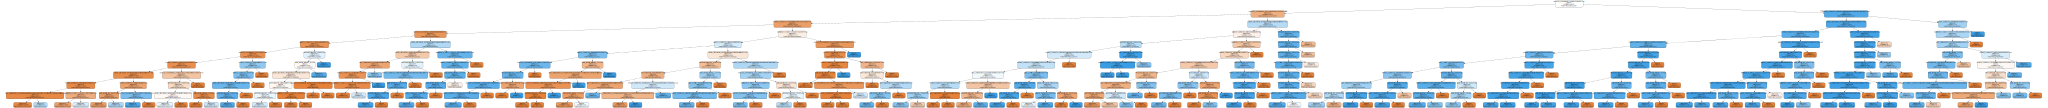

In [153]:
# Eksportowanie drzewa do pliku DOT
export_graphviz(dtc, out_file='tree.dot', feature_names=X_train.columns, filled=True, rounded=True)

# Konwersja pliku DOT na obraz
with open('tree.dot') as f:
    dot_graph = f.read()

file_name = "TREE_" + name + "_BEST_PARAMS_" + str(best_params)
graphviz.Source(dot_graph)
#graphviz.Source(dot_graph).render(file_name, format="png")
# files.download(file_name + '.png')